In [1]:
! pip install scikit-uplift -qqq

<div style="width: 100%; font-family: Trebuchet MS; font-weight: bold;">
    <div style="padding-top: 40%; position: relative; background-color: #000000; border-radius:10px;">
        <div style="background-image: url('https://i.imgur.com/Msbm2IA.jpeg'); background-size: cover; background-position: center; position: absolute; top: 0; left: 0; right: 0; bottom: 0; opacity: 0.5; border-radius:10px">
        </div>
        <div style="position: absolute; top: 0; left: 0; right: 0; bottom: 0;">
            <div style="position: relative; display: table; height: 75%; width: 100%;">
            </div>
            <div style="position: absolute; bottom: 30px; left: 30px;">
            </div>
        </div>
    </div>
</div>

<br>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#686dec'>WHAT WE WILL DO IN THIS SECTION</span></b></p></div>

In today's post we'll go through a predictive modeling technique known as **Uplift Modeling**. It is a technique that allows us to identify the subset of customers who are likely to be positively influenced by a marketing plot, and visa versa, those who we dont disturb will not respond to our action.


## <b>1 <span style='color:#686dec'>|</span> BACKGROUND</b> 

### **<span style='color:#686dec'> Problem Formulation</span>**

What is the main issue at hand:

- We cannot do an action & not do an action at the same time to the same person

So what it this modeling approach about:

**Uplift modeling** is a technique that allows us to identify the subset of objects 

- who upon being influenced by an event/action will do some action
- and if not influenced will not do the action

<b>AN EXAMPLE</b>

So lets think of an example:

Imagine we are selling a product and need to decide to whom we will be advertising, we have some constraints and cannot show it to all target audiences, 

- **we would like to find clients who will buy the product** if they see our advertisement 
- and **will and not buy it if they don't see it**

<b> WHAT DO WE NEED FOR UPLIFT MODELING</b>

In **uplift modeling** we need three components:

 Have two arrays we will be working with; **Treatment Array**, **Target Array** and standard **customer related feature matrix**

 - The **treatment array** is a binary vector, where we have no influence (0) and influenced (1)
 - The **target vector** is also a binary vector, where we have no action (0) and action is made (1)
 - The standard feature matrix (like other machine learning problems)

### **<span style='color:#686dec'> What to remember</span>**

So some important things to note in the context of uplift modeling:

- To model which users will do an action when influenced & users which will not do an action when not influences we need to have aside from a standard feature matrix two additional vectors; **treatment** (users were identified and interacted with) & the result of our interaction with them, stored in the **target vector**
- Having a trained model will enable us to identify on unseen data (without a treatment or target vector) the uplift value for a group for which we have a set of features used in training
- Our aim is to target **influencible clients** (those who upon being interacted with will commit a target action) and those when not interacted with will not conduct a target action.

## <b>2 <span style='color:#686dec'>|</span> DATASET</b> 

### **<span style='color:#686dec'> Loading Dataset</span>**

The dataset that we will use is found in the library **sklift**

In [2]:
import pandas as pd
from sklift.datasets import fetch_x5, fetch_lenta, clear_data_dir, fetch_megafon, fetch_hillstrom

data = fetch_hillstrom() # Kevin Hillstrom Dataset

# define feature matrix
#   "    treatment vector 
#   "    target vector 
X, y, t = data['data'],  data['target'], data['treatment']

Hillstrom dataset:   0%|          | 0.00/443k [00:00<?, ?iB/s]

Lets introduce ourselves to the dataset we will be using in our notebook, by looking at the description provided with the dataset

> This dataset contains 64,000 customers who last purchased within twelve months.
> The customers were involved in an e-mail test.
>
> * 1/3 were randomly chosen to receive an e-mail campaign featuring Mens merchandise.
> * 1/3 were randomly chosen to receive an e-mail campaign featuring Womens merchandise.
> * 1/3 were randomly chosen to not receive an e-mail campaign.
>
> During a period of two weeks following the e-mail campaign, results were tracked.
> Your job is to tell the world if the Mens or Womens e-mail campaign was successful.

Having read the above, lets **summarise the important** bits:

- We have 64000 customers who recently made a purchase, for these customers we have a matrix of features relevant to each of these customers
- We randomly send emails to these customers (**treatment array**); we have an array containing a marketing campaign defined subset groupings
- Finally we have a target containing post marketing campaign monitored results (confirmations of whether the email campaign worked or not)

In [3]:
X.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web


In [4]:
t

0        Womens E-Mail
1            No E-Mail
2        Womens E-Mail
3          Mens E-Mail
4        Womens E-Mail
             ...      
63995      Mens E-Mail
63996      Mens E-Mail
63997      Mens E-Mail
63998    Womens E-Mail
63999      Mens E-Mail
Name: segment, Length: 64000, dtype: object

## <b>3 <span style='color:#686dec'>|</span> PREPROCESSING</b> 

### **<span style='color:#686dec'> Problem Simplification</span>**

Lets do a little bit of preprocessing and problem simplification. As we saw in the above data, we have three categories in our treatment vector. Lets simplify it to just a binary case and not differentiate the male and female target cases, ie. marketing email has been sent or not sent. 

In [5]:
t = t.map({'Womens E-Mail':1, 'Mens E-Mail':1, 'No E-Mail':0})
t.head()

0    1
1    0
2    1
3    1
4    1
Name: segment, dtype: int64

### **<span style='color:#686dec'> Train/Test Splitting</span>**

In our modeling approach, we will need to train our model on one set of data and test it on another set of data, so we can evaluate its ability to generalise on unseen data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, 
                                                                     y, t, 
                                                                     test_size=0.3, 
                                                                     random_state=42)

print(X_train.shape)
print(X_test.shape)

(44800, 8)
(19200, 8)


### **<span style='color:#686dec'> Categorical Feature Treatment</span>**

To utilise the text based features in our feature matrix, we need to convert them into a numerical representation, one commonly used approach is One-Hot Encoding

In [7]:
# Categorical Features
cat_columns = ['history_segment', 'zip_code', 'channel']
enc = OneHotEncoder(sparse=False)

X_train_cat = enc.fit_transform(X_train[cat_columns])
X_train_cat = pd.DataFrame(X_train_cat, 
                           index=X_train.index,
                           columns=enc.get_feature_names_out(cat_columns))

X_test_cat = enc.transform(X_test[cat_columns])
X_test_cat = pd.DataFrame(X_test_cat, 
                          index=X_test.index,
                          columns=enc.get_feature_names_out(cat_columns))

X_train = pd.concat([X_train_cat, X_train.drop(cat_columns, axis=1)], axis=1)
X_test = pd.concat([X_test_cat, X_test.drop(cat_columns, axis=1)], axis=1)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
X_test.columns

Index(['history_segment_1) $0 - $100', 'history_segment_2) $100 - $200',
       'history_segment_3) $200 - $350', 'history_segment_4) $350 - $500',
       'history_segment_5) $500 - $750', 'history_segment_6) $750 - $1,000',
       'history_segment_7) $1,000 +', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web', 'recency', 'history', 'mens', 'womens', 'newbie'],
      dtype='object')

In [9]:
X_train.head()

,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,recency,history,mens,womens,newbie
9656,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,7,434.35,1,0,1
63037,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,376.59,1,0,0
31405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,140.34,0,1,1
58088,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3,150.76,0,1,0
44344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2,67.97,1,0,1


## <b>4 <span style='color:#686dec'>|</span> MODELING APPROACHES</b> 

Now that we have our data ready, lets talk libraries and approaches. There is a commonly used uplift modeling library called **scikit-uplift**, its based on scikit-learn machine learning models, but modified for uplift modeling. Lets remind ourselves of what the modeling actually wants to achieve:

> Uplift modeling focuses on predicting the impact of a treatment or intervention on an individual's behavior

scikit-uplift has a number of different approaches for uplift modeling, you can find the models in the [following link](https://www.uplift-modeling.com/en/latest/), we'll look at two of the three approaches used in the library

### **<span style='color:#686dec'> One Model Approach</span>**

Starting with **s-learner** approach, we train two separate models

- We train a base model with all base features, together with the treatment vector (w), taking the target vector (y) as our independent variable
- Apply the model (predict) assuming we have **interacted with all customers**, ie. (t=1 for all customers), and ask to return the probability of a successful outcome (y=1) for this group
- Apply the model (predict) again but assuming that these has been **no interaction** with any customer (t=0 for all customers)

![](https://i.imgur.com/Bq3JYHL.png)

The difference between these two vectors will be taken as our uplift, to be more specific:

> model generates **uplift scores** that represent the **estimated impact of a treatment** on each individual's behavior

The **s-learner** model can be used by importing **SoloModel** from `from sklift.models import SoloModel`

- We just need to specify the base model we will be using in the two models and wrap it with **SoloModel**.
- Like other sklearn models, we use **fit,predict** methods, but with an additional input `t_train`

In [10]:
model_predictions = dict()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklift.models import SoloModel

name = 'slearner'

base_model = RandomForestClassifier(random_state=42)
uplift_model = SoloModel(base_model)
uplift_model = uplift_model.fit(X_train, y_train, t_train)

# store the uplift values
model_predictions[name] = uplift_model.predict(X_test)

In [12]:
# We obtain our uplift values:
pred1 = uplift_model.predict(X_test)
print(pred1)
print(pred1.shape)

[-0.03 -0.31 -0.01 ...  0.03  0.56  0.14]
(19200,)


**Interpretation of Results:**
 
- If the results are positive for a particular entry, it indicates that the treatment (email marketing campaign) has a positive effect on this individual and visa versa.
- In terms of **magnitude**, a larger positive (or negative) uplift score implies a more significant impact of the treatment on the individual's likelihood of a positive outcome.


### **<span style='color:#686dec'> Two Independent Model Approach</span>**

The two model approach, **t-learner** is similar to a one model approach, however instead of training a single model on **all the data**, we train two models, on two different subsets of data:

- One for the **control group** (no interaction, t=0)
- Another for the **test group** (there was interaction, t=1)

![](https://i.imgur.com/iT6gZhI.png)

In order to obtain the uplift, we apply the model on the test set like in the **s-learner**, with the exception that we dont add the additional treatment feature, instead we are using two independent models. The difference in predict_proba between these two models will be our uplift value.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklift.models import TwoModels

name = 'tlearner'

# control group
basic_model_control = RandomForestClassifier(random_state=42)

# test group
basic_model_test = RandomForestClassifier(random_state=42)

uplift_model = TwoModels(basic_model_test, basic_model_control, method='vanilla')
uplift_model = uplift_model.fit(X_train, y_train, t_train)

# store the uplift values
model_predictions[name] = uplift_model.predict(X_test)

In [14]:
X_test.columns

Index(['history_segment_1) $0 - $100', 'history_segment_2) $100 - $200',
       'history_segment_3) $200 - $350', 'history_segment_4) $350 - $500',
       'history_segment_5) $500 - $750', 'history_segment_6) $750 - $1,000',
       'history_segment_7) $1,000 +', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web', 'recency', 'history', 'mens', 'womens', 'newbie'],
      dtype='object')

In [15]:
# We obtain our uplift values:
pred2 = uplift_model.predict(X_test)
print(pred2)
print(X_test.shape)
print(pred2.shape)

[ 0.         -0.41       -0.01       ...  0.08142857  0.59
  0.22      ]
(19200, 18)
(19200,)


We can also plot the uplift values predicted by both modeling approaches:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


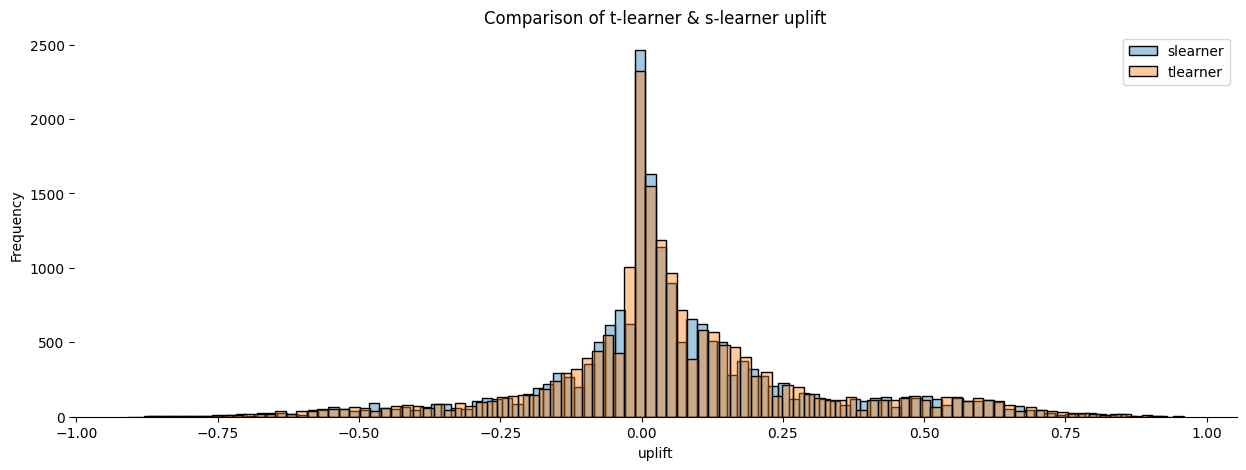

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
sns.despine(left=True,right=True,top=True)

sns.histplot(model_predictions['slearner'],bins=100,alpha=0.4,label='slearner',edgecolor='k',linewidth=1,ax=ax)
sns.histplot(model_predictions['tlearner'],bins=100,alpha=0.4,label='tlearner',edgecolor='k',linewidth=1,ax=ax)
ax.set_xlabel('uplift')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of t-learner & s-learner uplift')
ax.legend()

We can notice a very minor binomial tendency in the figure, a large portion of users having a low uplift values around 0-0.25 & a secondary group around 0.3-0.75, in terms of model variation, we can clearly note that **t-learner** is less concentrated with values at 0 and instead has more values in the region 0-0.25, which would indicate that the model predicts on average that the user is more confident that the user is positively influenced than the **s-model**

## <b>5 <span style='color:#686dec'>|</span> AFTER MODELING PROCESS</b> 

### **<span style='color:#686dec'> Metric Evaluation</span>**

So now that we have obtained our **uplift values**, we ought to evaluate how well our modeling is. When it comes to uplift modeling problems, we can turn to a metric called **uplift@k**. 

The metric ranges from -1 to 1, where **1 is the best** and **-1 represents a model that doesnt work**. A value of **0 is equivalent to a random model**. Values in the range 0.05 to 1 can be considered as working models.

The evaluation methodology is as follows:

- We take k objects with the highest uplift values
- Divide the subset into a **contol** (t=0) and **test** (t=1) group
- Evaluate the average target y for each individually
- Find the difference:

    $$ uplift@k = \bar{y}_{k \space test} - \bar{y}_{k \space control} $$

    $$ \bar{y}_k = \frac{1}{n} \sum_{i=1}^{k}{uplift_i,}  $$


There are some [other metrics](https://www.uplift-modeling.com/en/latest/) you can look into as well:

- Area Under Uplift Curve
- Area Under Qini Curve
- Weighted average uplift

In [17]:
from sklift.metrics import uplift_at_k

results = dict()
for model_name, preds in model_predictions.items():
    
    up_k_best = uplift_at_k(y_true=y_test, 
                            uplift=preds, 
                            treatment=t_test, 
                            strategy='overall', 
                            k=0.2)
    
    results[model_name] = round(up_k_best,4)

In [18]:
results

{'slearner': 0.0526, 'tlearner': 0.0584}

What we can conclude is that the **t-learner** method has a slightly higher metric values compared to **s-learer**, which indicates that it is a slightly better modeling approach.

### **<span style='color:#686dec'> Applying Models</span>**

So we have a model, now lets apply it on unseen data. We have prepared a new set of customers using the same logic as before, creating the same features. We utilise the model on our new dataset and obtain the uplift values for each customer in our new client batch. Lets define some uplift criteria for filtering out clients to whom we wish to send an identical marketing campaign as before. Based on the what the model learned in the previous data, clients with a high uplift will likely end up going through with the purchases, our marketing campaign should just remind them of the opporunity we are providing them, and the feedback is expected to be mostly positive.

In [19]:
client_batch = pd.concat([X_test.reset_index(drop=True),pd.Series(pred2,name='uplift')],axis=1)
marketing_clients = client_batch[client_batch['uplift'] > 0.3]

In [20]:
# clients 
marketing_clients

,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,recency,history,mens,womens,newbie,uplift
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,261.23,1,1,1,0.38
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5,55.56,0,1,0,0.44
17,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,966.24,1,0,1,0.49
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,610.09,1,1,1,0.55
37,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10,138.32,1,0,1,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19160,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3,948.12,1,0,1,0.55
19166,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,10,742.80,1,1,1,0.31
19180,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2,1240.88,0,1,1,0.53
19186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,697.47,1,0,1,0.33


## <b>6 <span style='color:#686dec'>|</span> CONCLUDING REMARKS</b> 

In this post we looked into a brief introduction into **uplift modeling**, which is a practical business task for which we can utilise machine learning & use modeling for the prediction/identification of the subset of objects/dataset **who upon being influenced by an event/action will do some action** and **if not influenced will not do the action**

We looked at two approaches **s-learner** & **t-learner** modeling approaches and tried a sample problem **Kevin Hillstrom Dataset**

The modeling approaches allow us to predict the lift value, and gives us to understanding how well the particular client is influenced based on historical data, the models can then be used on new unseen data.

We can repeat the process similar to above using some other datasets such as: [fetch_x5](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_x5.html), [fetch_lenta](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html#lenta-uplift-modeling-dataset), [fetch_megafon](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_megafon.html).
